In [1]:
# Load libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.utils import class_weight
from sklearn.metrics import recall_score, precision_score, f1_score, classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Embedding, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from gensim.models import Word2Vec
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors

from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
def eval_metrics(model, X_train, X_test):
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    print('\0033[1m' + 'Test Set:' + '\033[0m')
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print('\0033[1m' + 'Trajn Set:' + '\033[0m')
    print(confusion_matrix(y_train, y_pred_train))
    print(classification_report(y_train, y_pred_train)) 

(400000, 100)

In [5]:
# Loading the data
df = pd.read_pickle('clean_data_1608221436.pkl')

df['clean_text_lemmas'] = [' '.join(text) for text in df['lemmas']]
df['clean_text_lemmas'] = df['clean_text_lemmas'].astype('str')

In [73]:
# Subset the features
X = df.lemmas_small
y = df.target

In [83]:
# Create toeknizer to have numaric values for the sequences
tokenizer = Tokenizer(num_words=6200, filters=None)

# Tokenize the text
tokenizer.fit_on_texts(X)

# Converting tokens to Numeric values
X_num_tokens = tokenizer.texts_to_sequences(X)

# Maximum number of tokens for all docuemnt
num_tokens = [len(tokens) for tokens in X_num_tokens]
num_tokens = np.array(num_tokens)

print('max_lenght : ', num_tokens.max())
print('mean_lenght : ', num_tokens.mean())
max_tokens = num_tokens.max()
print(' max_tokens : ', num_tokens.max())
print('% data used : ', sum(num_tokens < max_tokens)/len(num_tokens))

max_lenght :  21
mean_lenght :  6.2062261920399315
 max_tokens :  21
% data used :  0.9998686457375542


In [84]:
len(X_num_tokens)

7613

In [85]:
# Fixing token cpounts of all docuemnts(pad_seq)
X_pad = pad_sequences(X_num_tokens, maxlen=max_tokens)

In [23]:
# Glove Model
glove_model = 'glove.6B.100d.txt'
word2vec = 'glove.6B.100d.word2vec'
glove2word2vec(glove_model, word2vec)

wv_model = KeyedVectors.load_word2vec_format(word2vec)

In [81]:
words = list(tokenizer.word_index.keys())

In [177]:
words.remove('ombudsmanship')

In [178]:
# Creating the corpus for Word embedding
corpus = []
for text in df.lemmas.values:
    corpus.append(text)

embedding_size = 100
num_words = 6200

# Create the embedding matrix with the train weights for DL model
embedding_matrix = np.random.uniform(-1,1, (num_words, embedding_size))
for i, word in enumerate(words):
    if i < num_words:
        embedding_vector = wv_model[word]
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [179]:
# Perform a test/train split
X_train, X_test, y_train, y_test = train_test_split(X_pad, y, stratify= y, test_size=0.3, random_state=42)

In [258]:
# Selecting the Sequential model
model = Sequential()
model.add(Embedding(input_dim=num_words,
                    output_dim=embedding_size,
                    weights=[embedding_matrix],
                    input_length=21,
                    trainable=True,
                    name='embedding_layer'))
model.add(Dropout(0.4))
model.add(GRU(units=48, return_sequences=True))
model.add(Dropout(0.4))
model.add(GRU(units=24, return_sequences=True))
model.add(Dropout(0.4))
model.add(GRU(units=12))
model.add(Dense(1, activation='sigmoid'))

In [259]:
optimizer = Adam(learning_rate = 0.005)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [260]:
early_stop = EarlyStopping(monitor="val_accuracy", mode="max", 
                           verbose=1, patience = 2, restore_best_weights=True)

In [261]:
model.fit(X_train, y_train, epochs=25, batch_size=96,
         validation_data=(X_test, y_test), callbacks=[early_stop])

Epoch 1/25
56/56 [==============================] - 13s 109ms/step - loss: 0.6439 - accuracy: 0.6346 - val_loss: 0.5675 - val_accuracy: 0.7150
Epoch 2/25
56/56 [==============================] - 4s 78ms/step - loss: 0.5019 - accuracy: 0.7664 - val_loss: 0.4850 - val_accuracy: 0.7881
Epoch 3/25
56/56 [==============================] - 4s 76ms/step - loss: 0.4045 - accuracy: 0.8272 - val_loss: 0.4995 - val_accuracy: 0.7855
Epoch 4/25
56/56 [==============================] - 4s 79ms/step - loss: 0.3429 - accuracy: 0.8617 - val_loss: 0.4917 - val_accuracy: 0.7846
Epoch 4: early stopping


In [262]:
model_loss = pd.DataFrame(model.history.history)
model_loss.head()

,loss,accuracy,val_loss,val_accuracy
0,0.643891,0.634641,0.567547,0.714974
1,0.501921,0.766373,0.485046,0.788091
2,0.404529,0.827172,0.499512,0.785464
3,0.342920,0.861700,0.491741,0.784588


<AxesSubplot:>

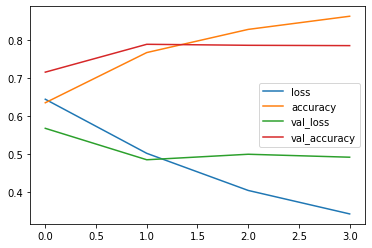

In [263]:
model_loss.plot()

In [264]:
def eval_metrics(model, X_train, X_test):
    y_pred = model.predict(X_test) > 0.5
    y_pred_train = model.predict(X_train) > 0.5
    print('\0033[1m' + 'Test Set:' + '\033[0m')
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print('\0033[1m' + 'Train Set:' + '\033[0m')
    print(confusion_matrix(y_train, y_pred_train))
    print(classification_report(y_train, y_pred_train)) 

In [265]:
eval_metrics(model, X_train, X_test)

167/167 [==============================] - 2s 10ms/step
3Test Set:
[[1089  214]
 [ 270  711]]
              precision    recall  f1-score   support

           0       0.80      0.84      0.82      1303
           1       0.77      0.72      0.75       981

    accuracy                           0.79      2284
   macro avg       0.78      0.78      0.78      2284
weighted avg       0.79      0.79      0.79      2284

3Train Set:
[[2752  287]
 [ 468 1822]]
              precision    recall  f1-score   support

           0       0.85      0.91      0.88      3039
           1       0.86      0.80      0.83      2290

    accuracy                           0.86      5329
   macro avg       0.86      0.85      0.85      5329
weighted avg       0.86      0.86      0.86      5329



In [268]:
df_test = pd.read_pickle('clean_data_1608221848.pkl')

In [269]:
df_test

,id,text,cleaned_text,lemmas,lemmas_small
0,0,Just happened a terrible car crash,just happened terrible car crash,"[just, happen, terrible, car, crash]","[just, happen, terrible, car, crash]"
1,2,"Heard about #earthquake is different cities, s...",heard about earthquake different cities stay s...,"[hear, earthquake, different, city, stay, safe]","[hear, earthquake, different, city, stay, safe]"
2,3,"there is a forest fire at spot pond, geese are...",there forest fire spot pond geese are fleeing ...,"[forest, spot, pond, goose, flee, street, not,...","[forest, spot, pond, goose, flee, street, not,..."
3,9,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting. spokane wildfires,"[apocalypse, lighting, spokane, wildfire]","[apocalypse, lighting, wildfire]"
4,11,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kills china and taiwan,"[typhoon, soudelor, kill, china, taiwan]","[typhoon, kill, china]"
...,...,...,...,...,...
3258,10861,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,earthquake safety los angeles ûò safety faste...,"[earthquake, safety, los, angeles, ûò, safety...","[earthquake, safety, safety, fastener]"
3259,10865,Storm in RI worse than last hurricane. My city...,storm worse than last hurricane. others hardes...,"[storm, bad, hurricane, hard, hit, yard, look,...","[storm, bad, hurricane, hard, hit, yard, look,..."
3260,10868,Green Line derailment in Chicago http://t.co/U...,green line derailment chicago,"[green, line, derailment, chicago]","[green, line, derailment]"
3261,10874,MEG issues Hazardous Weather Outlook (HWO) htt...,meg issues hazardous weather outlook hwo,"[meg, issue, hazardous, weather, outlook, hwo]","[issue, hazardous, weather, outlook]"


In [270]:

X_num_tokens_test = tokenizer.texts_to_sequences(df_test.lemmas_small)

In [271]:
# Maximum number of tokens for all docuemnt
num_tokens = [len(tokens) for tokens in X_num_tokens_test]
num_tokens = np.array(num_tokens)

print('max_lenght : ', num_tokens.max())
print('mean_lenght : ', num_tokens.mean())
max_tokens = num_tokens.max()
print(' max_tokens : ', num_tokens.max())
print('% data used : ', sum(num_tokens < max_tokens)/len(num_tokens))

max_lenght :  15
mean_lenght :  5.865461231995097
 max_tokens :  15
% data used :  0.9993870671161508


In [272]:
# Fixing token cpounts of all docuemnts(pad_seq)
X_pad_test = pad_sequences(X_num_tokens_test, maxlen=21)

In [274]:
df_test['target'] = model.predict(X_pad_test)

102/102 [==============================] - 1s 8ms/step


In [277]:
df_test = df_test[['id','target']]

In [278]:
df_test['target'] = df_test.target.apply(lambda x : 1 if x > 0.5 else 0)

In [280]:
df_test.to_csv('submission2.csv', index=False)